In [29]:
#Paraphrase detection with a classifier using BERT representation
#THis notebook is based on the Microsoft Research paraphrase corpus where a classifier is trained to detect paraphrases

In [30]:
import os 
import pandas as pd
import seaborn as sns
import torch.multiprocessing as torch_mp
import torch
from transformers import BertTokenizer, BertModel
from transformers import pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
import matplotlib.pyplot as plt
import operator
import optuna

In [31]:
model = BertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
def make_segment_ids(list_of_tokens):
    #this function assumes that up to and including the first '[SEP]' is the first segment, anything afterwards is the second segment
    current_id=0
    segment_ids=[]
    for token in list_of_tokens:
        segment_ids.append(current_id)
        if token == '[SEP]':
            current_id +=1
    return segment_ids

def tokenize(text):
    text = 'CLS' + text + 'SEP'
    tokens = tokenizer.tokenize(text)
    ids = tokenizer.convert_tokens_to_ids(tokens)
    seg = make_segment_ids(tokens)

    return ids, seg

def load_tsv(tsv_text):
    content = dict()
   
    temp1 = []; temp2 = []; temp3 = []; temp4 = []; temp5 = []
    with open(tsv_text, 'r') as tr:
        for line in tr:
            line = line.split('\t')
            temp1.append(line[0])
            temp2.append(line[1])
            temp3.append(line[2])
            temp4.append(line[3])
            temp5.append(line[4])

    content["Quality"] = temp1[1:]; content["#1 ID"] = temp2[1:]; content["#2 ID"] = temp3[1:]
    content["#1 String"] = temp4[1:]; content["#2 String"] = temp5[1:]

    return content

def plot_confusion_matrix(y_preds, y_true, labels):
    """Plotting confusion matrix given predicted y(y_pred), true y(y_true) and labels"""
    cm = confusion_matrix(y_true, y_preds, labels, normalize= True)
    fig,ax = plt.subplots(len(labels), len(labels))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= labels)
    disp.plot(cmap= "Blues", values_format =".2f", ax = ax, colorbar = False)
    plt.title("Normalized confusion matrix")
    plt.show()

def cross_val_w_gridsearch(x, y, model, params, cv_method = KFold, num_of_splits = 8, method = "grid"):

    """Already defined splits, x-labels are ndarrays and Model is already initialised y - labels are also ndarrays"""
    
    output = []
    try:
        kf = cv_method(num_of_splits, shuffle = True, random_state = 10 )
        splits = kf.split(y)
    except ModuleNotFoundError:
        print("Import {} module".format(cv_method))
    
    if method.lower() == "grid" or "random":
        print(method)
        gridsearch = GridSearchCV(model, params, n_jobs = 10) 

        for train,val in splits:    

            gridsearch.fit(x[train],y[train])
            best_xgb_model = model.set_params(**gridsearch.best_params_)

            best_xgb_model.fit(x[train], y[train])
            pred = best_xgb_model.predict(x[val])

            pred = np.round(pred, 0) #rounded up in order to match labels
            ref =  y[val]

            #using accuracy as a metric to evaluate models
            f1 = f1_score(pred,ref, average = "weighted")
            output.append((f1,best_xgb_model,))
    else:
        print("select either 'grid' or 'random'")
    return output

In [33]:
MRPC = "/users/max/Desktop/NLP/Advanced_NLP/Deep_Learning_Transformers_Week7/lab8/MRPC"

os.listdir(MRPC)

train = MRPC + '/msr_paraphrase_train.txt'
dev = MRPC + '/msr_paraphrase_dev.tsv'
test = MRPC + '/msr_paraphrase_test.txt'

label2id = {1: "paraphrase", 0: "not paraphrase"}

In [34]:
columns = ["Quality", "#1 ID", "#2 ID", "#1 String", "#2 String"]

In [35]:
raw_train = pd.DataFrame(load_tsv(train))
raw_dev = pd.DataFrame(load_tsv(dev))
raw_test = pd.DataFrame(load_tsv(test))

In [36]:
#Obtaining token ids using BERT Tokenizer for train,dev and test split
 
train_1_id, train_1_seg_id = zip(*raw_train["#1 String"].map(tokenize)) #unpacks 
train_2_id, train_2_seg_id= zip(*raw_train["#2 String"].map(tokenize)) 

dev_1_id, dev_1_seg_id = zip(*raw_dev["#1 String"].map(tokenize)) 
dev_2_id, dev_2_seg_id = zip(*raw_dev["#2 String"].map(tokenize)) 

test_1_id, test_1_seg_id = zip(*raw_test["#1 String"].map(tokenize))
test_2_id, test_2_seg_id  = zip(*raw_test["#2 String"].map(tokenize))

#Obtaining labels to be used in classification head
train_labels = raw_train["Quality"]; dev_labels = raw_dev["Quality"]; test_labels = raw_test["Quality"]

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def out_hidden_states(text, flag = "tensor"):

    """Switches between Arrays and Tensors"""

    input = tokenizer(text, return_tensors ="pt")
    ins = {k:v.to(device) for k,v in input.items()}

    with torch.no_grad():
        out = model(**ins)[-2]

        if flag == "array":
            out = out[:,0].cpu().numpy()[:,:]

        elif flag == "tensor": 
            out = out[:, 0]

        else :
            print("select 'tensor' or 'array' ")

    return out

In [68]:
raw_train

,Quality,#1 ID,#2 ID,#1 String,#2 String
0,1,702876,702977,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr..."
1,0,2108705,2108831,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...
2,1,1330381,1330521,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ..."
3,0,3344667,3344648,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set..."
4,1,1236820,1236712,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...
...,...,...,...,...,...
4071,1,1620264,1620507,""" At this point , Mr. Brando announced : ' Som...","Brando said that "" somebody ought to put a bul..."
4072,0,1848001,1848224,"Martin , 58 , will be freed today after servin...",Martin served two thirds of a five-year senten...
4073,1,747160,747144,""" We have concluded that the outlook for price...","In a statement , the ECB said the outlook for ..."
4074,1,2539933,2539850,The notification was first reported Friday by ...,MSNBC.com first reported the CIA request on Fr...


In [ ]:
#Checking function per input
out_hidden_states(raw_train['#1 String'][0]).max()

USING NEURAL LAYER

In [88]:
train_string_1 = raw_train["#1 String"]
train_string_2 = raw_train['#2 String']

dev_string_1 = raw_dev['#1 String']
dev_string_2 = raw_dev['#2 String']

test_string_1 = raw_test['#1 String']
test_string_2 = raw_test['#2 String']

train_string_1 = [out_hidden_states(text, flag = "tensor") for text in train_string_1]
train_string_1 = torch.cat(train_string_1, dim = 0)

train_string_2 = [out_hidden_states(text, flag = "tensor") for text in train_string_2]
train_string_2 = torch.cat(train_string_2, dim = 0)

dev_string_1 = [out_hidden_states(text, flag = "tensor") for text in dev_string_1]
dev_string_1 = torch.cat(dev_string_1, dim = 0)

dev_string_2 = [out_hidden_states(text, flag = "tensor") for text in dev_string_2]
dev_string_2 = torch.cat(dev_string_2, dim = 0)

test_string_1 = [out_hidden_states(text, flag = "tensor") for text in test_string_1]
test_string_1 = torch.cat(test_string_1, dim = 0)

test_string_2 = [out_hidden_states(text, flag = "tensor") for text in test_string_2]
test_string_2 = torch.cat(test_string_2, dim = 0)

In [96]:
train = torch.cat((train_string_1, train_string_2), dim = 1)
dev = torch.cat((dev_string_1, dev_string_2), dim = 1)
test  = torch.cat((test_string_1, test_string_2), dim = 1)

In [94]:
train.shape

torch.Size([4076, 1536])

In [104]:
import torch.nn as nn

class pp_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(768*2,2)
        self.dropout = nn.Dropout()
        
    def forward(self, inputs:torch.tensor):
        x = self.l1(inputs)
        return x

#Assess impact of dropout on classifier performance

In [146]:
def accuracy(y_true, y_pred):
    corr = 0
    if len(y_true) == len(y_pred):
        for a,b in zip(y_true, y_pred):
            if a == b:
                corr += 1
            else:
                pass
        print("The Accuracy of this prediction is {}".format(corr/len(y_true)))
    else:
        print("y_true is not the same as y_pred")
        pass
    return corr/len(y_true)

def accuracy_tensor(probs: torch.FloatTensor, targets: torch.LongTensor) -> float:
    """
    Args:
        probs: A float32 tensor of shape ``(batch_size, class_count)`` where each value 
            at index ``i`` in a row represents the score of class ``i``.
        targets: A long tensor of shape ``(batch_size,)`` containing the batch examples'
            labels.
    """
    predicted = probs.argmax(dim=1)
    corrects = (predicted == targets)
    accuracy = corrects.sum().float() / float( targets.size(0) )
    return accuracy

In [137]:
train_labels = raw_train["Quality"]
train_labels = train_labels.map(float)

paraphrase_model = pp_model()
logits = paraphrase_model.forward(train)

logits = torch.argmax(logits, dim = 1)
output = list(logits.cpu().numpy())

The Accuracy of this prediction is 0.5836604514229637


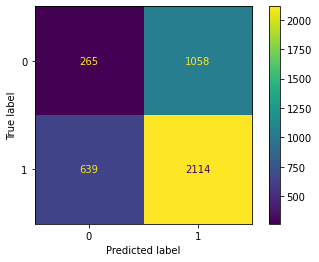

In [127]:
from sklearn.metrics import ConfusionMatrixDisplay
accuracy(output, train_labels)
ConfusionMatrixDisplay.from_predictions(train_labels, output)

TRAIN ON TRAIN_SET

In [141]:
torch.tensor(train_labels)

tensor([1., 0., 1.,  ..., 1., 1., 0.], dtype=torch.float64)

In [153]:
from torch import optim

train_labels = torch.tensor(raw_train['Quality'].map(float), dtype = torch.long)
optimizer = optim.SGD(paraphrase_model.parameters(), lr=0.05)

criterion = nn.CrossEntropyLoss()
paraphrase_model.train()

for epoch in range(0, 100):   

    logits = paraphrase_model.forward(train)
    loss = criterion(logits, train_labels)

    print("epoch: {} train accuracy: {:2.2f}, loss: {:5.5f}".format(epoch,accuracy_tensor(logits, train_labels) * 100,loss.item()))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()



/var/folders/3v/kl4z85b17kd84k1hy0srlb3w0000gn/T/ipykernel_24086/992723211.py:3: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  train_labels = torch.tensor(raw_train['Quality'].map(float), dtype = torch.long)


epoch: 0 train accuracy: 67.54, loss: 3.88844
epoch: 1 train accuracy: 72.18, loss: 0.83615
epoch: 2 train accuracy: 43.06, loss: 1.62465
epoch: 3 train accuracy: 67.54, loss: 3.69859
epoch: 4 train accuracy: 73.26, loss: 0.74140
epoch: 5 train accuracy: 49.51, loss: 1.30256
epoch: 6 train accuracy: 67.57, loss: 3.17526
epoch: 7 train accuracy: 73.09, loss: 0.62014
epoch: 8 train accuracy: 73.72, loss: 0.61559
epoch: 9 train accuracy: 72.47, loss: 0.61876
epoch: 10 train accuracy: 73.63, loss: 0.68011
epoch: 11 train accuracy: 53.34, loss: 1.11318
epoch: 12 train accuracy: 67.62, loss: 2.84428
epoch: 13 train accuracy: 68.94, loss: 0.67780
epoch: 14 train accuracy: 70.12, loss: 1.13091
epoch: 15 train accuracy: 37.98, loss: 2.03015
epoch: 16 train accuracy: 67.54, loss: 4.15574
epoch: 17 train accuracy: 70.58, loss: 0.99942
epoch: 18 train accuracy: 39.25, loss: 1.93269
epoch: 19 train accuracy: 67.54, loss: 4.05038
epoch: 20 train accuracy: 71.25, loss: 0.93274
epoch: 21 train accurac

In [ ]:
#plot training loss chart
#plot validation loss
#Set up if statement for when training loss less than validation loss